#### Task 2-2: Implementing CNN with Softmax-cross entropy

#### The network is working for a single image and ReLu activation. Backpropagation is also based on ReLu function. Maxpooling is applied at FF and BP

In [1]:
# array processing for numbers, strings, records, and objects
import numpy as np
from sklearn.metrics import confusion_matrix
#Used for generating random number or sequences
import random
#Used for plotting(Use this for visualization)
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.image as mpimg
import glob, os
import time
# import cv2
from scipy import signal
from skimage.measure import block_reduce

In [2]:
def initializeNetwork(netStruct, activation, alpha, hidN, X_train, yTrain):
    numClasses = yTrain.shape[0]
    
    Net = []
    layer = {'a1': X_train}
    Net.append(layer)
    prevDepth = X_train.shape[2]
    inSize = X_train.shape
    for id in range(len(netStruct)):
        layerParams = netStruct[id]
        if layerParams['type'] == 'c':
            fan_in = layerParams['kernelsize'] * layerParams['kernelsize'] * prevDepth * layerParams['outputmaps']
            k = np.random.randn(layerParams['kernelsize'],layerParams['kernelsize'],prevDepth, layerParams['outputmaps'])/np.sqrt(fan_in)
            b = np.zeros((layerParams['outputmaps'],1), dtype = float)
#             print(inSize[0]-layerParams['kernelsize']+1, inSize[0]-layerParams['kernelsize']+1, layerParams['outputmaps'])
            outSize = np.array([inSize[0]-layerParams['kernelsize']+1, inSize[0]-layerParams['kernelsize']+1, layerParams['outputmaps']], dtype = int)
#             outSize = np.reshape(outSize, (outSize.shape[0], 1))
            inSize = outSize
            print('Filters :', k.shape, '  bias :', b.shape)
            print('Output layer :', outSize)
            layer = {'type': 'c','kernel': k, 'bias': b, 'activation': activation, 'lr': alpha, 'outSize': outSize}
            Net.append(layer)
            prevDepth = layerParams['outputmaps']
#             print(k.shape, b.shape)
        elif layerParams['type'] == 's':
            layer = layerParams
            outSize = np.array([(inSize[0])/layer['stride'], (inSize[0])/layer['stride'], outSize[2]] , dtype = int)
            inSize = outSize
            layer['outSize'] = outSize
            print('Output layer :', outSize)
            Net.append(layer)
    
    inputDimension = inSize[0]*inSize[1]*inSize[2]
    for id in range(hidN.shape[0]):
        w1 = np.random.randn(inputDimension,hidN[id])/np.sqrt(inputDimension)
        b1 = np.zeros((hidN[id],1), dtype = float)
        print('w1 shape :', w1.shape, 'b1 shape :', b1.shape)
        layer = {'w': w1, 'bias': b1, 'activation': activation, 'lr': alpha}
        Net.append(layer)
        inputDimension = hidN[id]
        
    w1 = np.random.randn(inputDimension,numClasses)/np.sqrt(inputDimension)
    b1 = np.zeros((numClasses,1), dtype = float)
    print('w1 shape :', w1.shape, 'b1 shape :', b1.shape)
    layer = {'w': w1, 'bias': b1, 'activation': 'Softmax', 'lr': alpha}
    Net.append(layer)
    
    return Net# model

def forwardPropagation(model, inputSample):
    layer = model[0]
    layer['a1'] = inputSample
    model[0] = layer
    for l in range(1, 5):
        pLayer = model[l-1]
        layer = model[l]
        outSize = layer['outSize']
        inputImages = pLayer['a1']
#         b = layer['bias']
        if layer['type'] == 'c':
            featureMap = np.zeros(outSize, dtype = float)
            localGrad = np.zeros(outSize, dtype = float)
            for j in range(outSize[2]):
                outImage = np.zeros((outSize[0], outSize[1]), dtype = float)
                for i in range(layer['kernel'].shape[2]):
                    outImage = outImage + convol2d(inputImages[:,:,i], layer['kernel'][:,:,i, j])
                
                outImage = outImage + layer['bias'][j]
#                 featureMap[:,:,j] = actFunctionSig(outImage)
                featureMap[:,:,j] = relu(outImage)
                localGrad[:,:,j] = 1*(featureMap[:,:,j]>0)
                
#             print(featureMap.shape)
            layer['a1'] = featureMap
            layer['lg'] = localGrad
            model[l] = layer
        elif layer['type'] == 's':
#             print('ss layer')
            featureMap = np.zeros(outSize, dtype = float)
            maxLocs = np.zeros(pLayer['outSize'], dtype = float)
            for j in range(outSize[2]):
                featureMap[:,:,j], maxLocs[:,:,j] = maxPool(inputImages[:,:,j], layer['stride'])
                
#             print(featureMap.shape)
            layer['a1'] = featureMap
            layer['mlocs'] = maxLocs
            model[l] = layer
                   
    inputSample = np.reshape(featureMap, (featureMap.shape[0]*featureMap.shape[1]*featureMap.shape[2], 1))
    layer['a11'] = inputSample
    model[5-1] = layer
    for l in range(5, len(model)):
        layer = model[l]
        w1 = layer['w']
#         print('w shape :', w1.shape)
        z1 = (w1.T.dot(inputSample)) + layer['bias']
        if layer['activation'] == 'relu':
            a1 = relu(z1)
            localGrad = 1*(a1>0)
        else:
            a1 = actFunctionSof(z1)
            localGrad = 1*(a1>0) # at this point location of max is not important
        layer['a1'] = a1
        layer['lg'] = localGrad
        model[l] = layer
        inputSample = a1
#     print(a1.shape)
    return model
    
    
def actFunctionSig (z):
    a = 1/(1+np.exp(-z))
    return a

def actFunctionSof (z):
    a = np.exp(z)/sum(np.exp(z))
    return a

def lossCalculation(model, actual_target):
    
    layer = model[len(model)-1]
    a1 = layer['a1']
#     print(a1)
    # uncoment the following line for softmax cross entopy loss
    loss = -((actual_target * np.log(a1)).sum())/actual_target.shape[1]

    # uncomment the following line for softmax L2 loss
#     loss = (sum(sum((actual_target - a1)**2)))/(2*actual_target.shape[1])

    return loss

def backprop(model, actual_target):
    # Change weights for last layer
#     print ('calculating weight change in layer :', len(model)-1)
    layer = model[len(model)-1]
    a1 = layer['a1']
    
    layer_1 = model[len(model)-2]
    a1_1 = layer_1['a1']
#     print(a1.shape, actual_target.shape)
    #uncomment the folowing lines sofmax cross entropy loss
    dzl = (a1 - actual_target)
    dbl = np.sum(a1 - actual_target, axis=1)

    #uncomment the folowing line sofmax L2 loss
#     dzl = ((a1-actual_target)*(a1*(1-a1)))/a1.shape[1]
#     dbl = np.sum(dzl, axis=1)
    
    # Weights change
    dwl = a1_1.dot(dzl.T)

    layer['dw'] = dwl
    layer['db'] = dbl
    layer['delta'] = dzl
    model[len(model)-1] = layer

    # Change weights for remaining layers
    for rId in range(len(model)-2,4,-1):
#         print ('calculating weight change in layer :', rId)
        layer_p = model[rId+1]
        layer_c = model[rId]
        layer_n = model[rId-1]
        a1 = layer_c['a1']
        localGrad = layer_c['lg']
    
#         dz = (a1*(1-a1))*((layer_p['w']).dot( layer_p['delta']))
        dz = localGrad*((layer_p['w']).dot( layer_p['delta']))
        if rId-1 == 4:
            dw = (layer_n['a11']).dot(dz.T)
        else:
            dw = (layer_n['a1']).dot(dz.T)
        db = np.sum(dz, axis=1)
        layer_c['dw'] = dw
        layer_c['db'] = db
        layer_c['delta'] = dz
        model[rId] = layer_c
    
    layer_p = model[4+1]
    dz = (layer_p['w']).dot( layer_p['delta'])
    layer = model[4]
    oSize = layer['a1'].shape
    newDz = np.reshape(dz, oSize)
    layer['delta'] = newDz
    model[4] = layer.copy()
    
    
#     print(layer['a1'].shape)
#     print(newDz.shape)
    
    for l in range(3,0,-1):
        
        prLayer = model[l+1]
        dzp = prLayer['delta']
#         print('layer number - ', l)
        layer = model[l]
        outSize = layer['outSize']
#         print(layer)
        if layer['type'] == 'c':
#             print('Conv layer gradeints')
            dz = np.zeros(outSize, dtype = float)
            for j in range(outSize[2]):
#                 dz[:,:,j] = (layer['a1'][:,:,j]*(1-layer['a1'][:,:,j]))* np.repeat(np.repeat(dzp[:,:,j], 2, axis=0), 2, axis=1)
                dz[:,:,j] = (layer['lg'][:,:,j])* prLayer['mlocs'][:,:,j] *np.repeat(np.repeat(dzp[:,:,j], 2, axis=0), 2, axis=1)
#             print(dz.shape)
            layer['delta'] = dz
            model[l] = layer
        elif layer['type'] == 's':
#             print('ss layer BP')
            gradMap = np.zeros(outSize, dtype = float)
            pOutSize = prLayer['outSize']
            for i in range(outSize[2]):
                outGrad = np.zeros((outSize[0], outSize[1]), dtype = float)
                for j in range(pOutSize[2]):
                    temp = np.lib.pad(prLayer['delta'][:,:,j], prLayer['kernel'][:,:,i,j].shape[0]-1, 'constant', constant_values=0)
#                     outGrad = outGrad + convol2d(temp, prLayer['kernel'][:,:,i, j])
                    outGrad = outGrad + convol2d(temp, flip180(prLayer['kernel'][:,:,i, j]))
            
                gradMap[:,:,i] = outGrad
                
            layer['delta'] = gradMap
            model[l] = layer
            
    for l in range(1, 5):
        pLayer = model[l-1]
        layer = model[l]
        outSize = layer['outSize']
        inputImages = pLayer['a1']
        if layer['type'] == 'c':
            dk = np.zeros(layer['kernel'].shape, dtype = float)
            db = np.zeros(layer['bias'].shape, dtype = float)
            for j in range(outSize[2]):
                outImage = np.zeros((outSize[0], outSize[1]), dtype = float)
                for i in range(pLayer['a1'].shape[2]):
                    dk[:,:,i,j] = convol2d(flip180(pLayer['a1'][:,:,i]), layer['delta'][:,:, j])
                
                db[j,0] = (layer['delta'][:,:, j]).sum()
                
            layer['dk'] = dk
            layer['db'] = db
            model[l] = layer
#             print(dk.shape)
#             print(db.shape)

    return model

def updateWeights(model):
    # Update weights for CONV layers
    for l in range(1, 5):
        pLayer = model[l-1]
        layer = model[l]
        outSize = layer['outSize']
        inputImages = pLayer['a1']
        if layer['type'] == 'c':
            for j in range(outSize[2]):
                for i in range(pLayer['a1'].shape[2]):
                    layer['kernel'][:,:,i,j] = layer['kernel'][:,:,i,j] - alpha * layer['dk'][:,:,i,j]
                
                
                layer['bias'][j,0] = layer['bias'][j,0] - alpha * layer['db'][j,0]
                
            model[l] = layer
            
    # Update weights for Fully connected layers
    for wId in range(5, len(model)):
#         print ('updating weights in layers :', wId)
        layer = model[wId]
    
        db = layer['db']
        db = np.array((np.matrix(db)).T)
        layer['db'] = db
        layer['w'] = layer['w'] - layer['lr']*layer['dw']
        layer['bias'] = layer['bias'] - layer['lr']*layer['db']
        model[wId] = layer
        
    return model
    

def trainModel(model, x_train, y_train,x_test, y_test, numberOfEpochs):
    trainLoss = []
    validLoss = []
    dShape = x_train.shape
    oShape = y_train.shape
    for ep in range(numberOfEpochs):
        lossB = []
        idx = np.random.permutation(dShape[3])
        bSize = 1
        batches = int(dShape[3]/bSize)
#         print(idx)
        start = 0
        for id in range(batches):
            indices = idx[start:start+bSize]
            inputSample = np.reshape(x_train[:,:,:,indices], (dShape[0], dShape[1], dShape[2]))
            outVal = np.reshape(y_train[:,indices], (oShape[0], 1))        
            model = forwardPropagation(model, inputSample)
            loss = lossCalculation(model, outVal)
            model = backprop(model, outVal)
            model = updateWeights(model)
            lossB.append(loss)
            start = start + bSize
#             print('Batch loss :',loss)
        vLoss = validateModel(model, x_test, y_test)
        validLoss.append(vLoss)
        trainLoss.append(np.mean(np.array(lossB)))
        print('Training loss epoch ('+str(ep+1) +')----> :', np.mean(np.array(lossB)))
        print('Validation loss epoch ('+str(ep+1) +')----> :', vLoss)
#     model.append(lossAll)
    xAxis = np.linspace(1,numberOfEpochs,numberOfEpochs)
    plt.plot(xAxis, np.array(trainLoss), label="Train Loss")
    plt.plot(xAxis, np.array(validLoss), label="Validation Loss")
    plt.xlabel('No. Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.title('Training & Validation Loss')
    plt.show()
    
    return model
#         print(np.mean(np.array(lossEp)))
        
def evaluate_model(model, x_test, y_test):
    dShape = x_test.shape
    oShape = y_test.shape

    outLabes = np.zeros((1,oShape[1]), dtype = int)
    for id in range(oShape[1]):
        inputSample = np.reshape(x_test[:,:,:,id], (dShape[0], dShape[1], dShape[2]))
        outVal = np.reshape(y_test[:,id], (oShape[0], 1))
            
        model = forwardPropagation(model, inputSample)
        layer = model[-1]
        a1 = layer['a1']
        outLabes[0, id] = a1.argmax(axis=0)
        
    OrigLabels = y_test.argmax(axis=0)
    outLabes.reshape(OrigLabels.shape)
    # print(outLabes.shape, OrigLabels.shape)
    correct = outLabes == OrigLabels
    accuracy = 100*sum(correct.T)/correct.shape[1]
    return accuracy


def readImages(iType):
    label = []
    imagesAll = np.zeros((28,28, 1), dtype=float)
    for fol in range(10):

        mypath='Task1_Data/'+iType+'/' + str(fol)
        onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
        images = np.zeros((28,28, len(onlyfiles)), dtype=float)
        for id in range(len(onlyfiles)):
            path = mypath + '/'+onlyfiles[id]
            img=mpimg.imread(path)
            images[:,:,id] = img
            label.append(fol)

        imagesAll = np.concatenate((imagesAll, images), axis=2)
    return imagesAll, label

def validateModel(model, x_test, y_test):
    dShape = x_test.shape
    oShape = y_test.shape
    print('Test Data : ', dShape)
    print('Test Output : ', oShape)
    validLoss = []
    for id in range(oShape[1]):
        inputSample = np.reshape(x_test[:,:,:,id], (dShape[0], dShape[1], dShape[2]))
        outVal = np.reshape(y_test[:,id], (oShape[0], 1))
            
        model = forwardPropagation(model, inputSample)
#         print('done')
        loss = lossCalculation(model, outVal)
        validLoss.append(loss)
    return np.mean(np.array(validLoss))

def oneHot(Y_train, numClasses):
    yTrain = np.zeros((numClasses ,Y_train.shape[1]), dtype=int)
    for ii in range(Y_train.shape[1]):
        yTrain[Y_train[0,ii], ii] = 1
    return yTrain

def convol2d(image, kernel):
    built_in = 1
    if built_in ==1:
        # Built-in function for convolution
        outImage = signal.convolve(image, kernel, "valid")
    else:

        # function written for manual convolution
        outSize = image.shape[0]-kernel.shape[0]+1
        outImage = np.zeros((outSize ,outSize), dtype=float)
        for i in range(outSize):
            for j in range(outSize):
                patch = image[i:i+kernel.shape[0], j:j+kernel.shape[0]]
                outImage[i, j] = (patch*kernel).sum()
                
    return outImage
            
def relu(outImage):
    return np.maximum(0,outImage)

def maxPool(inputImage, stride):
#     outImage = block_reduce(inputImage, block_size=(2,2), func=np.max)
    nsize = int(np.ceil(inputImage.shape[0]/stride))
#     print(nsize, stride)
    outImage = np.zeros((nsize ,nsize), dtype=float)
    outLocs = np.zeros(inputImage.shape, dtype=float)
    ii = 0
    for i in range(0, inputImage.shape[0], stride):
        jj = 0
        for j in range(0, inputImage.shape[1], stride):
            patch = inputImage[i:i+stride, j:j+stride]
            ab = np.zeros(patch.shape, dtype = int)
            id = np.unravel_index(patch.argmax(), patch.shape)
            ab[id] = 1
            outLocs[i:i+stride, j:j+stride] = ab
#             print(patch)
            outImage[ii, jj] = np.amax(patch)
#             loc = np.argmax(patch)
            jj = jj+1
        ii = ii+1
    return outImage, outLocs

def flip180(im):
    im = np.fliplr(np.flipud(im))
    return im

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
cfdata = unpickle('data_batch_1')
print(cfdata.keys())
data = cfdata[b'data']
labels = cfdata[b'labels']
names = cfdata[b'filenames']

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


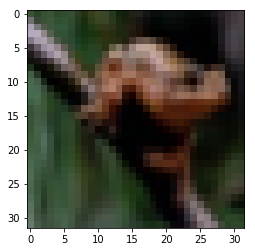

In [5]:
imagesAll = np.zeros((32,32,3,10000))
for id in range(len(labels)):
    image = np.zeros((32,32,3))
    im1 = np.reshape(data[id, 0:1024], (32, 32))
    im2 = np.reshape(data[id, 1024:2048], (32, 32))
    im3 = np.reshape(data[id, 2048:3072], (32, 32))
    image[:,:,0] = im1/255
    image[:,:,1] = im2/255
    image[:,:,2] = im3/255
    imagesAll[:,:,:, id] = image
# image = np.reshape(data[id, :], (32, 32, 3))
plt.imshow(imagesAll[:,:,:, 5000])
plt.show()

In [6]:
X_train = imagesAll.copy()
label = np.array(labels)
Y_train = np.reshape(label, (1,label.shape[0]))
yTrain = oneHot(Y_train, 10)
print('Batch-1 data shape :', X_train.shape)
print('Batch-1 labels shape :', yTrain.shape)

Batch-1 data shape : (32, 32, 3, 10000)
Batch-1 labels shape : (10, 10000)



#### Selecting a subset for training and testing data due to limitaion of computations

In [7]:
cSamples = 4000
sX_train = X_train[:,:,:,0:cSamples]
sY_train = yTrain[:,0:cSamples]
tSamples = 800
sX_test = X_train[:,:,:,cSamples:cSamples+tSamples]
sY_test = yTrain[:,cSamples:cSamples+tSamples]

print('Training data shape :', sX_train.shape)
print('Training labels shape :', sY_train.shape)
print('Testing data shape :', sX_test.shape)
print('Testing labels shape :', sY_test.shape)

Training data shape : (32, 32, 3, 4000)
Training labels shape : (10, 4000)
Testing data shape : (32, 32, 3, 800)
Testing labels shape : (10, 800)



##### Define CNN structure

In [8]:
netStruct = []
layer = {'type': 'c', 'outputmaps': 8, 'kernelsize': 5}
netStruct.append(layer)
layer = {'type': 's', 'scale': 2, 'stride': 2}
netStruct.append(layer)
layer = {'type': 'c', 'outputmaps': 16, 'kernelsize': 5}
netStruct.append(layer)
layer = {'type': 's', 'scale': 2, 'stride': 2}
netStruct.append(layer)

#### Network with two Conv and pooling layers each followed by two hidden layers with [256, 64] neurons

Filters : (5, 5, 3, 8)   bias : (8, 1)
Output layer : [28 28  8]
Output layer : [14 14  8]
Filters : (5, 5, 8, 16)   bias : (16, 1)
Output layer : [10 10 16]
Output layer : [ 5  5 16]
w1 shape : (400, 256) b1 shape : (256, 1)
w1 shape : (256, 64) b1 shape : (64, 1)
w1 shape : (64, 10) b1 shape : (10, 1)
Model Accuracy after 0 epochs:  [ 8.5]
Test Data :  (32, 32, 3, 800)
Test Output :  (10, 800)
Training loss epoch (1)----> : 2.20082506278
Validation loss epoch (1)----> : 1.99021433357
Test Data :  (32, 32, 3, 800)
Test Output :  (10, 800)
Training loss epoch (2)----> : 1.98696110825
Validation loss epoch (2)----> : 1.95092195726


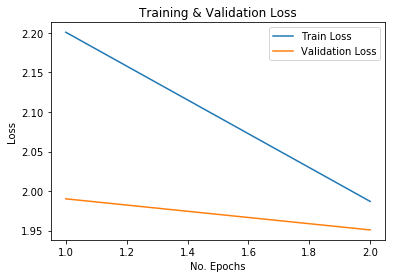

Model Accuracy after 2 epochs:  [ 26.375]


In [9]:
activation = 'relu' # Except last layer where activation is sigmoid
hidN = np.array([256, 64])
alpha = 0.01
numberOfEpochs = 2

inputDimension = X_train.shape[0]

# if want to load trained model uncomment the following line and comment the initializeNetwork function
# model = np.load('ModelmNIst.npy')

model = initializeNetwork(netStruct, activation, alpha, hidN, sX_train, sY_train)
accuracy = evaluate_model(model, sX_test, sY_test)
print('Model Accuracy after '+str(0) +' epochs: ', accuracy)

model = trainModel(model, sX_train, sY_train,sX_test, sY_test, numberOfEpochs)
accuracy = evaluate_model(model, sX_test, sY_test)
print('Model Accuracy after '+str(numberOfEpochs) +' epochs: ', accuracy)

In [80]:
np.save('ModelCifar10', model)
# validateModel(model, sX_test[:,:,:,0:2], sY_test[:,0:2])
# # evaluate_model(model, sX_test[:,:,:,0:2], sY_test[:,0:2])